In [ ]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')
df['CrimeDate'] = pd.to_datetime(df['CrimeDate'], format="mixed")

In [ ]:
#extracting required rows from the entire dataset
burglary_indices_train, larceny_indices_train = [], []
burglary_indices_test, larceny_indices_test = [], []

for index, row in df.iterrows():
    rowdate = int(row.CrimeDate.year)
    if rowdate in [2014, 2015, 2016]:
        if row.CrimeCode[0] == '5':
            if rowdate != 2016:
                burglary_indices_train.append(index)
            else:
                burglary_indices_test.append(index)
        elif row.CrimeCode[0] == '6':
            if rowdate != 2016:
                larceny_indices_train.append(index)
            else:
                larceny_indices_test.append(index)

In [ ]:
df_burglary_train = df.iloc[burglary_indices_train].groupby('CrimeDate').sum(numeric_only=True)
df_larceny_train = df.iloc[larceny_indices_train].groupby('CrimeDate').sum(numeric_only=True)
df_burglary_test = df.iloc[burglary_indices_test].groupby('CrimeDate').sum(numeric_only=True)
df_larceny_test = df.iloc[larceny_indices_test].groupby('CrimeDate').sum(numeric_only=True)

In [ ]:
train_data_larceny = df_larceny_train['Total Incidents'].values
test_data_larceny = df_larceny_test['Total Incidents'].values
train_data_burglary = df_burglary_train['Total Incidents'].values
test_data_burglary = df_burglary_test['Total Incidents'].values

In [ ]:
scaler_larceny = MinMaxScaler()
train_data_larceny = scaler_larceny.fit_transform(train_data_larceny.reshape(-1, 1))
test_data_larceny = scaler_larceny.transform(test_data_larceny.reshape(-1, 1))

scaler_burglary = MinMaxScaler()
train_data_burglary = scaler_burglary.fit_transform(train_data_burglary.reshape(-1, 1))
test_data_burglary = scaler_burglary.transform(test_data_burglary.reshape(-1, 1))

In [ ]:
#creating time series out of the extracted data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

In [ ]:
seq_length = 7

X_train_larceny = create_sequences(train_data_larceny, seq_length)
y_train_larceny = train_data_larceny[seq_length:]

X_test_larceny = create_sequences(test_data_larceny, seq_length)
y_test_larceny = test_data_larceny[seq_length:]

X_train_burglary = create_sequences(train_data_burglary, seq_length)
y_train_burglary = train_data_burglary[seq_length:]

X_test_burglary = create_sequences(test_data_burglary, seq_length)
y_test_burglary = test_data_burglary[seq_length:]


In [ ]:
X_train_larceny = X_train_larceny.reshape((X_train_larceny.shape[0], X_train_larceny.shape[1], 1))
X_test_larceny = X_test_larceny.reshape((X_test_larceny.shape[0], X_test_larceny.shape[1], 1))

X_train_burglary = X_train_burglary.reshape((X_train_burglary.shape[0], X_train_burglary.shape[1], 1))
X_test_burglary = X_test_burglary.reshape((X_test_burglary.shape[0], X_test_burglary.shape[1], 1))

In [ ]:
#function to train models
def train_model(X_train, y_train, X_test, y_test, model_type='RNN', loss='mse', epochs=100, batch_size=32):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

    if model_type == 'RNN':
        model.add(keras.layers.SimpleRNN(50, activation='relu', return_sequences=True))
        model.add(keras.layers.SimpleRNN(40, activation='relu', return_sequences=True))
        model.add(keras.layers.SimpleRNN(30, activation='relu', return_sequences=True))
        model.add(keras.layers.SimpleRNN(20, activation='relu', return_sequences=False))
    elif model_type == 'LSTM':
        model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True))
        model.add(keras.layers.LSTM(40, activation='relu', return_sequences=True))
        model.add(keras.layers.LSTM(30, activation='relu', return_sequences=True))
        model.add(keras.layers.LSTM(20, activation='relu', return_sequences=False))

    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss=loss)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    predictions = model.predict(X_test)

    if loss == 'mape':
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    else:
        mape = None

    return predictions, mape, model


In [ ]:
results = {
    'RNN_Larceny_MSE': {},
    'RNN_Larceny_MAPE': {},
    'RNN_Burglary_MSE': {},
    'RNN_Burglary_MAPE': {},
    'LSTM_Larceny_MSE': {},
    'LSTM_Larceny_MAPE': {},
    'LSTM_Burglary_MSE': {},
    'LSTM_Burglary_MAPE': {}
}

# RNN Larceny MSE
predictions_larceny_mse, mape_larceny_mse, model_rnn_larceny_mse = train_model(
    X_train_larceny, y_train_larceny, X_test_larceny, y_test_larceny,
    model_type='RNN', loss='mse'
)
results['RNN_Larceny_MSE'] = {'predictions': predictions_larceny_mse, 'mape': mape_larceny_mse}

# RNN Larceny MAPE
predictions_larceny_mape, mape_larceny_mape, model_rnn_larceny_mape = train_model(
    X_train_larceny, y_train_larceny, X_test_larceny, y_test_larceny,
    model_type='RNN', loss='mape'
)
results['RNN_Larceny_MAPE'] = {'predictions': predictions_larceny_mape, 'mape': mape_larceny_mape}

# RNN Burglary MSE
predictions_burglary_mse, mape_burglary_mse, model_rnn_burglary_mse = train_model(
    X_train_burglary, y_train_burglary, X_test_burglary, y_test_burglary,
    model_type='RNN', loss='mse'
)
results['RNN_Burglary_MSE'] = {'predictions': predictions_burglary_mse, 'mape': mape_burglary_mse}

# RNN Burglary MAPE
predictions_burglary_mape, mape_burglary_mape, model_rnn_burglary_mape = train_model(
    X_train_burglary, y_train_burglary, X_test_burglary, y_test_burglary,
    model_type='RNN', loss='mape'
)
results['RNN_Burglary_MAPE'] = {'predictions': predictions_burglary_mape, 'mape': mape_burglary_mape}

# LSTM Larceny MSE
predictions_larceny_mse_lstm, mape_larceny_mse_lstm, model_lstm_larceny_mse = train_model(
    X_train_larceny, y_train_larceny, X_test_larceny, y_test_larceny,
    model_type='LSTM', loss='mse'
)
results['LSTM_Larceny_MSE'] = {'predictions': predictions_larceny_mse_lstm, 'mape': mape_larceny_mse_lstm}

# LSTM Larceny MAPE
predictions_larceny_mape_lstm, mape_larceny_mape_lstm, model_lstm_larceny_mape = train_model(
    X_train_larceny, y_train_larceny, X_test_larceny, y_test_larceny,
    model_type='LSTM', loss='mape'
)
results['LSTM_Larceny_MAPE'] = {'predictions': predictions_larceny_mape_lstm, 'mape': mape_larceny_mape_lstm}

# LSTM Burglary MSE
predictions_burglary_mse_lstm, mape_burglary_mse_lstm, model_lstm_burglary_mse = train_model(
    X_train_burglary, y_train_burglary, X_test_burglary, y_test_burglary,
    model_type='LSTM', loss='mse'
)
results['LSTM_Burglary_MSE'] = {'predictions': predictions_burglary_mse_lstm, 'mape': mape_burglary_mse_lstm}

# LSTM Burglary MAPE
predictions_burglary_mape_lstm, mape_burglary_mape_lstm, model_lstm_burglary_mape = train_model(
    X_train_burglary, y_train_burglary, X_test_burglary, y_test_burglary,
    model_type='LSTM', loss='mape'
)
results['LSTM_Burglary_MAPE'] = {'predictions': predictions_burglary_mape_lstm, 'mape': mape_burglary_mape_lstm}


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


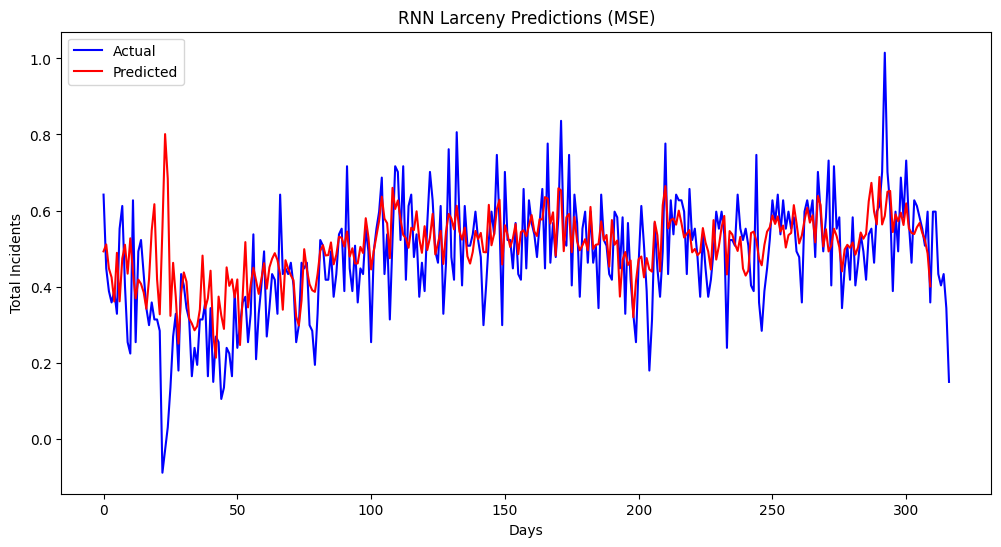

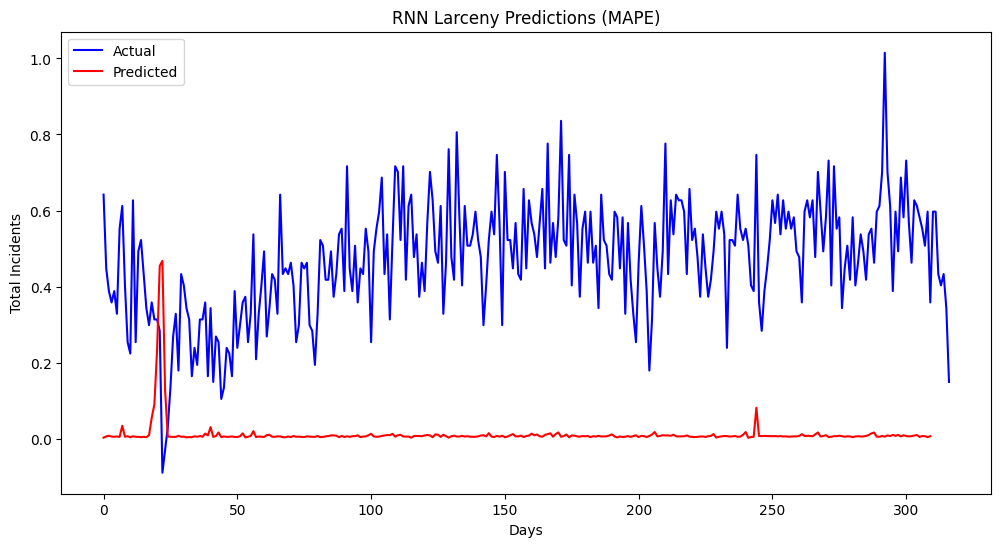

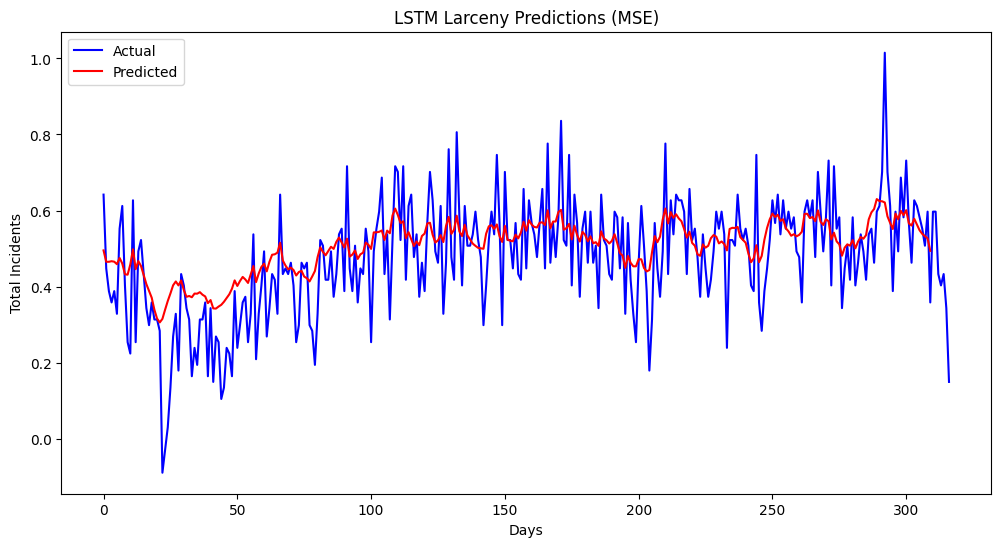

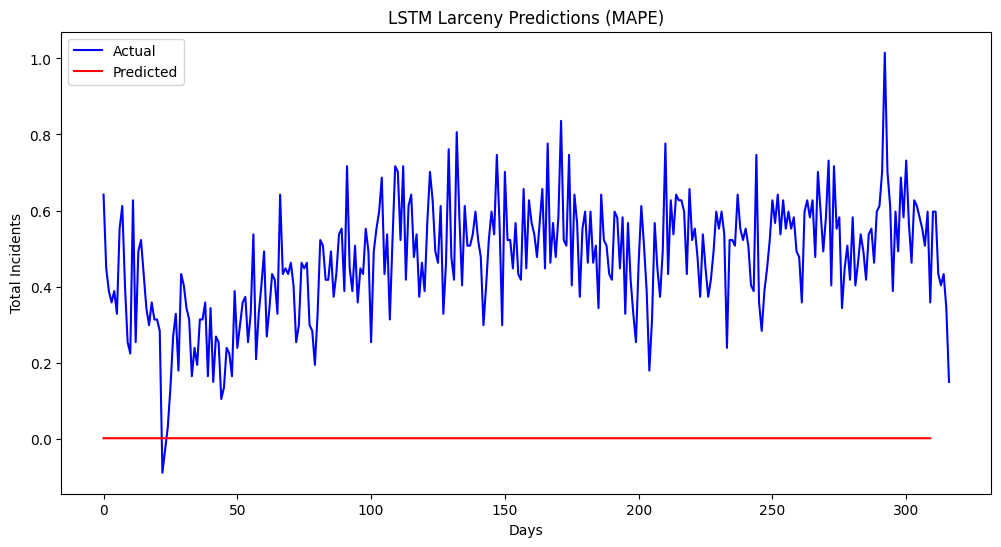

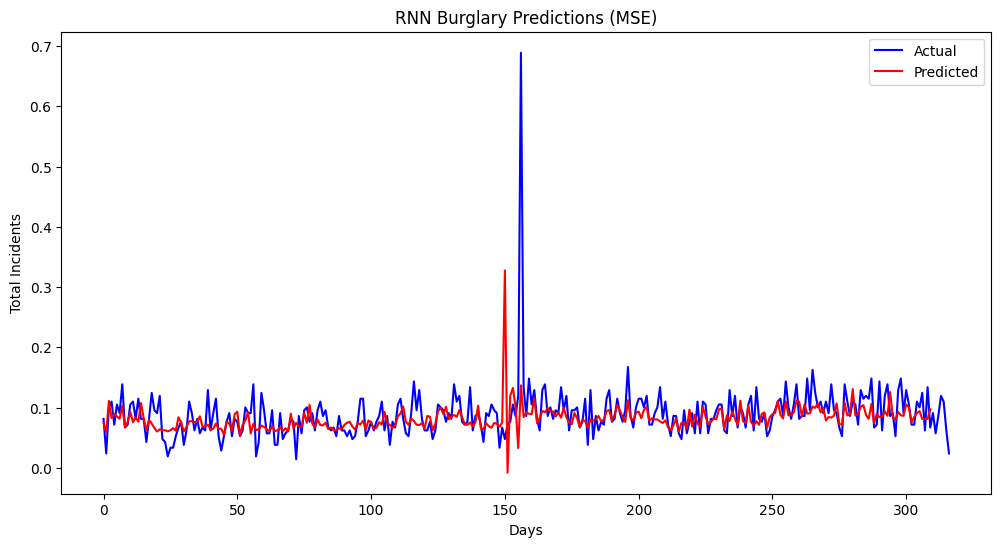

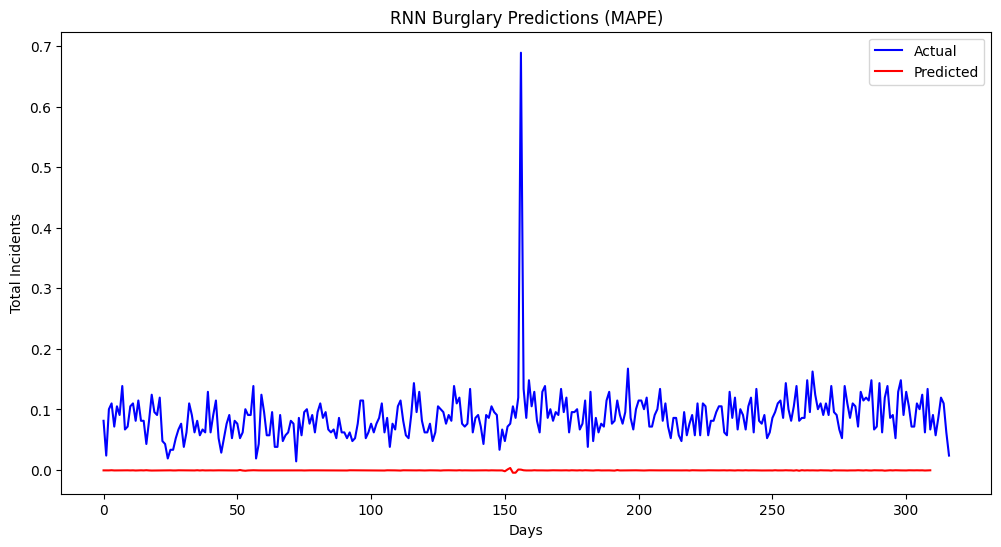

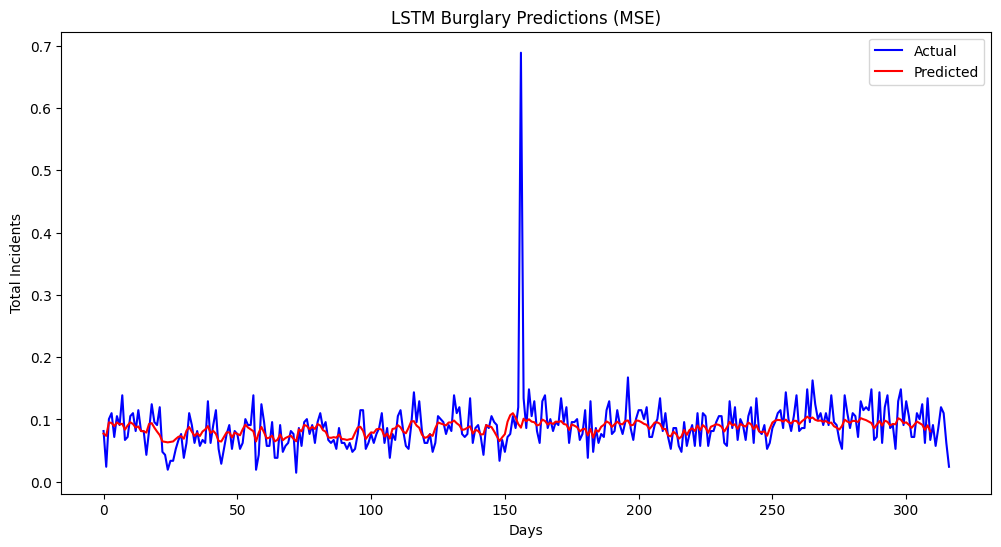

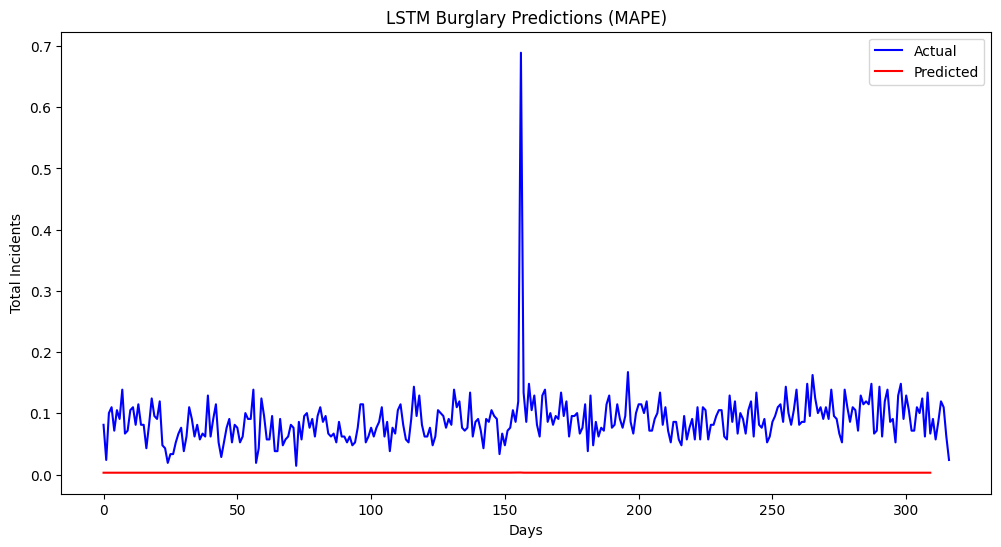

In [ ]:
#inference
def plot_results(actual_data, predictions, title):
    plt.figure(figsize=(12, 6))

    if isinstance(actual_data, (pd.DataFrame, pd.Series)):
        plt.plot(actual_data.index, actual_data.values, label='Actual', color='blue')
    else:
        plt.plot(range(len(actual_data)), actual_data, label='Actual', color='blue')

    plt.plot(range(len(predictions)), predictions, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Total Incidents')
    plt.legend()
    plt.show()


plot_results(test_data_larceny, results['RNN_Larceny_MSE']['predictions'], 'RNN Larceny Predictions (MSE)')
plot_results(test_data_larceny, results['RNN_Larceny_MAPE']['predictions'], 'RNN Larceny Predictions (MAPE)')
plot_results(test_data_larceny, results['LSTM_Larceny_MSE']['predictions'], 'LSTM Larceny Predictions (MSE)')
plot_results(test_data_larceny, results['LSTM_Larceny_MAPE']['predictions'], 'LSTM Larceny Predictions (MAPE)')

plot_results(test_data_burglary, results['RNN_Burglary_MSE']['predictions'], 'RNN Burglary Predictions (MSE)')
plot_results(test_data_burglary, results['RNN_Burglary_MAPE']['predictions'], 'RNN Burglary Predictions (MAPE)')
plot_results(test_data_burglary, results['LSTM_Burglary_MSE']['predictions'], 'LSTM Burglary Predictions (MSE)')
plot_results(test_data_burglary, results['LSTM_Burglary_MAPE']['predictions'], 'LSTM Burglary Predictions (MAPE)')
